# Project 4: Whale Calls



## Descripción general


**Conjunto de datos:** Llamados de ballenas para prevenir colisiones
El problema es clasificar un caso como ballena franca o no basándose en una señal de audio. Esos casos positivos contienen un conjunto de llamados ascendentes de ballena franca. Los llamados ascendentes son la vocalización de ballena franca más comúnmente documentada con una firma acústica de aproximadamente 60 Hz a 250 Hz, que generalmente dura 1 segundo. Cada serie está etiquetada como que contiene una ballena franca o no con el objetivo de identificar correctamente la serie que contiene llamados ascendentes. Los llamados de ballena franca a menudo pueden ser difíciles de escuchar ya que la banda de baja frecuencia puede congestionarse con sonidos antropogénicos como ruido de barcos, perforaciones, pilotes u operaciones navales.

Cada caso es un segmento de audio de dos segundos muestreado a 2 kHz, lo que da una longitud de serie de 4000.

**Instrucciones**


*   Analice y extraiga las características del conjunto de datos pertinentes al problema que seleccionó en el paso anterior. Justifique sus decisiones.
*   Elige al menos dos métodos (incluido al menos uno aprendido en clase) para resolver el desafío propuesto que seleccionaste. Justifica tus decisiones.
*   Informar las métricas adecuadas. Analizar y discutir los resultados de cada método.


## Importar librerias

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
# Configuración del dispositivo
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/MLP4/Proyecto 4/Dataset/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

Probando la apertura de algunos archivos .wav

In [ ]:
y, sr = librosa.load(path + "train/0.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feacture Vector of the Whale sound:" , feacture_vector)
Audio(data=y, rate=sr)


Feacture Vector of the Whale sound: [-6.6629205e+02  2.0302626e+02  1.2296489e+02  3.2377563e+01
 -3.5245567e+01 -5.9178642e+01 -4.2848377e+01 -7.9783320e+00
  1.9905506e+01  2.6018074e+01  1.1994647e+01 -8.6099272e+00
 -2.1085217e+01 -1.8900064e+01 -6.1726551e+00  7.0471926e+00
  1.2376251e+01  8.2582674e+00 -3.5707486e-01 -6.6166401e+00]


Extrayendo labels del csv a un diccionario

In [ ]:
df = pd.read_csv(path + 'train.csv', header=None)
# Convertir el DataFrame en un diccionario
data_dict = dict(zip(df.iloc[1:, 0], df.iloc[1:, 1]))
mapping = {'NoWhale': 0, 'RightWhale': 1}
converted_dict = {k: mapping[v] for k, v in data_dict.items()}
print(converted_dict)

{'0': 0, '1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1, '10': 1, '11': 0, '12': 0, '13': 0, '14': 1, '15': 0, '16': 1, '17': 0, '18': 1, '19': 0, '20': 1, '21': 1, '22': 1, '23': 1, '24': 0, '25': 0, '26': 0, '27': 1, '28': 1, '29': 1, '30': 1, '31': 0, '32': 1, '33': 0, '34': 1, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 1, '41': 1, '42': 0, '43': 1, '44': 0, '45': 1, '46': 0, '47': 1, '48': 1, '49': 0, '50': 0, '51': 0, '52': 1, '53': 1, '54': 0, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 0, '61': 0, '62': 1, '63': 0, '64': 1, '65': 0, '66': 1, '67': 1, '68': 0, '69': 0, '70': 1, '71': 1, '72': 0, '73': 0, '74': 0, '75': 0, '76': 1, '77': 0, '78': 0, '79': 1, '80': 1, '81': 1, '82': 1, '83': 0, '84': 1, '85': 0, '86': 0, '87': 1, '88': 1, '89': 0, '90': 0, '91': 0, '92': 1, '93': 1, '94': 1, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0, '100': 1, '101': 1, '102': 0, '103': 1, '104': 1, '105': 0, '106': 1, '107': 0, '108': 0, '109': 0, '110': 1,

In [ ]:
# Funciones de codificación de datos
def encode(path, data_type='train/'):
    data1 = []
    labels = []
    directory_1 = os.listdir(path + data_type)
    print(directory_1)
    i = 0
    for f in directory_1:
        y, sr = librosa.load(path + data_type + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data1.append(fv)
        labels.append(converted_dict[f.split('.')[0]])
        print(i)
        print(f)
        i += 1
    data = np.array(data1)
    labels = np.array(labels)
    return data, labels

In [ ]:
def encode2(path, data_type='test/'):
    data1 = []
    directory_1 = os.listdir(path + data_type)
    print(directory_1)
    i = 0
    for f in directory_1:
        y, sr = librosa.load(path + data_type + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data1.append(fv)
        print(i)
        print(f)
        i += 1
    data = np.array(data1)
    return data

In [ ]:
# Cargar y codificar datos
x_train, y_train = encode(path, data_type='train/')
x_test = encode2(path, data_type='test/')


Se truncaron las últimas líneas 5000 del resultado de transmisión.
4799.wav
10397
4800.wav
10398
4801.wav
10399
4802.wav
10400
4803.wav
10401
4804.wav
10402
4805.wav
10403
4806.wav
10404
4807.wav
10405
4808.wav
10406
4827.wav
10407
4845.wav
10408
4863.wav
10409
4881.wav
10410
4917.wav
10411
4935.wav
10412
4953.wav
10413
4980.wav
10414
4981.wav
10415
4982.wav
10416
4983.wav
10417
4984.wav
10418
4985.wav
10419
4986.wav
10420
4987.wav
10421
4988.wav
10422
4989.wav
10423
4990.wav
10424
4991.wav
10425
4992.wav
10426
4993.wav
10427
4994.wav
10428
4995.wav
10429
4996.wav
10430
4997.wav
10431
4998.wav
10432
4999.wav
10433
5016.wav
10434
5034.wav
10435
5052.wav
10436
5070.wav
10437
5089.wav
10438
5106.wav
10439
5124.wav
10440
5160.wav
10441
5161.wav
10442
5162.wav
10443
5163.wav
10444
5164.wav
10445
5165.wav
10446
5166.wav
10447
5167.wav
10448
5168.wav
10449
5169.wav
10450
5170.wav
10451
5171.wav
10452
5172.wav
10453
5173.wav
10454
5174.wav
10455
5175.wav
10456
5176.wav
10457
5177.wav
10458
517

## Data Train and Data Test

In [ ]:
# Dividir el conjunto de entrenamiento para obtener un conjunto de validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Métodos

## LSTM

In [ ]:
# Definir el modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Función de entrenamiento
def train(model, optimizer, criterion, num_epochs, x_train, y_train):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Calcular accuracy de entrenamiento
        train_predictions = torch.round(torch.sigmoid(outputs))
        train_accuracy = (train_predictions == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}')

    return train_losses, train_accuracies


In [ ]:
# Función de evaluación
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.view(-1))  # Asegurar que ambas dimensiones coincidan
            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:

# Convertir los datos a tensores de PyTorch
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 20).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).view(-1, 1, 20).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).view(-1, 1, 20).to(device)


In [ ]:
# Crear DataLoader para el conjunto de validación
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:

# Crear DataLoader para el conjunto de prueba
test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Parámetros del modelo
input_size = 20
hidden_size = 32
num_layers = 5
output_size = 1

# Instanciar el modelo
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [ ]:
# Definir criterio y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 1000
train_losses, train_accuracies = train(model, optimizer, criterion, num_epochs, x_train, y_train)

Epoch [0/1000], Train Loss: 0.4470, Train Acc: 0.7884
Epoch [100/1000], Train Loss: 0.4622, Train Acc: 0.7750
Epoch [200/1000], Train Loss: 0.4612, Train Acc: 0.7741
Epoch [300/1000], Train Loss: 0.4605, Train Acc: 0.7744
Epoch [400/1000], Train Loss: 0.4600, Train Acc: 0.7752
Epoch [500/1000], Train Loss: 0.4596, Train Acc: 0.7750
Epoch [600/1000], Train Loss: 0.4592, Train Acc: 0.7757
Epoch [700/1000], Train Loss: 0.4588, Train Acc: 0.7762
Epoch [800/1000], Train Loss: 0.4585, Train Acc: 0.7767
Epoch [900/1000], Train Loss: 0.4582, Train Acc: 0.7771


Validation Loss: 0.4786
Accuracy: 0.7691, Precision: 0.7927, Recall: 0.7330, F1 Score: 0.7617
Confusion Matrix:
[[875 211]
 [294 807]]


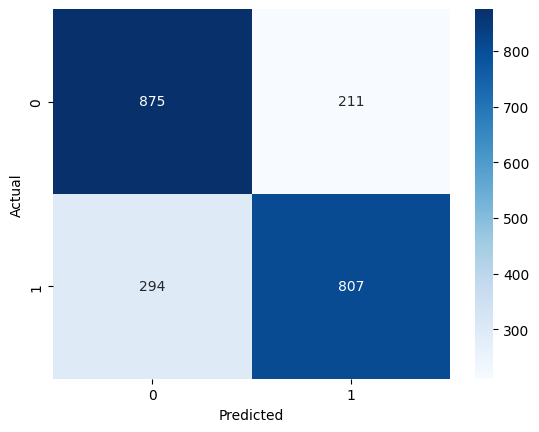

Predicciones guardadas en predictions.csv


In [ ]:
# Evaluar el modelo
evaluate(model, val_loader)
# Realizar predicciones en el conjunto de prueba
model.eval()
predictions = []

with torch.no_grad():
    for features in test_loader:
        features = features[0].to(device)
        outputs = model(features)
        predicted = torch.sigmoid(outputs.squeeze()).cpu().numpy()
        predicted = (predicted > 0.5).astype(int)  # Convertir a 0 o 1
        predictions.extend(predicted)

# Mapear las predicciones a las etiquetas originales
label_mapping = {0: 'NoWhale', 1: 'RightWhale'}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Crear un DataFrame con los índices y las predicciones
submission_df = pd.DataFrame({
    'idx': list(range(len(predicted_labels))),
    'class': predicted_labels
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('predictions7.csv', index=False)
print("Predicciones guardadas en predictions.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Resultados de optimizer para LSTM:
*   Adam: 0.51261
*   SGD: 0.60969
*   RMSprop: 0.55503
*   Adagrad: 0.51748
*   Adadelta: 0.52225
*   AdamW: 0.51072
*   NAdam: 0.48283

## Métricas

# Gráficas 📊

**Graficas** (Train dataset)

0    5467
1    5467
Name: count, dtype: int64


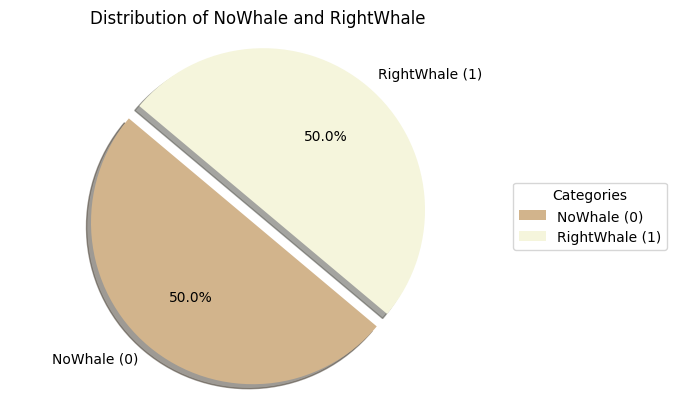

In [ ]:
# Recontar los valores de 0 y 1
value_counts = pd.Series(converted_dict.values()).value_counts()
print(value_counts)

labels = ['NoWhale (0)', 'RightWhale (1)']
sizes = [value_counts[0], value_counts[1]]
colors = ['Tan', 'beige']
explode = (0.1, 0)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

ax.legend(wedges, labels,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.title('Distribution of NoWhale and RightWhale')
plt.show()

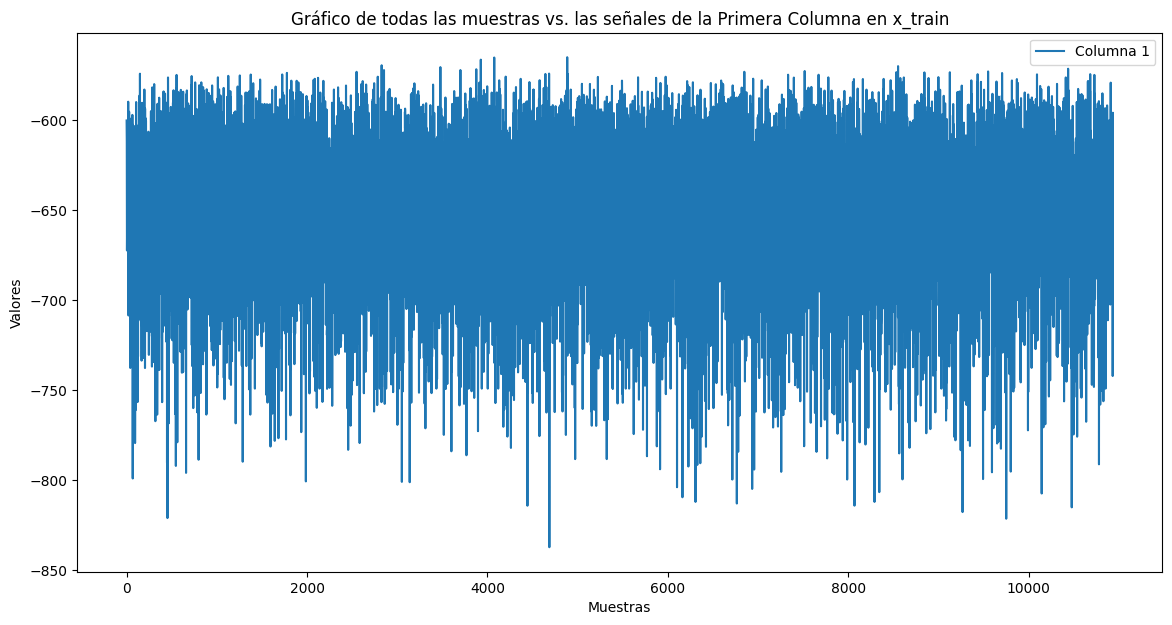

In [ ]:
# Gráfico de todas las filas vs. la primera columna (feature) de la matriz x_train
plt.figure(figsize=(14, 7))
for i in range(1):
    plt.plot(np.arange(x_train.shape[0]), x_train[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de todas las muestras vs. las señales de la Primera Columna en x_train')
plt.xlabel('Muestras')
plt.ylabel('Valores')..
.........
plt.legend()
plt.show()

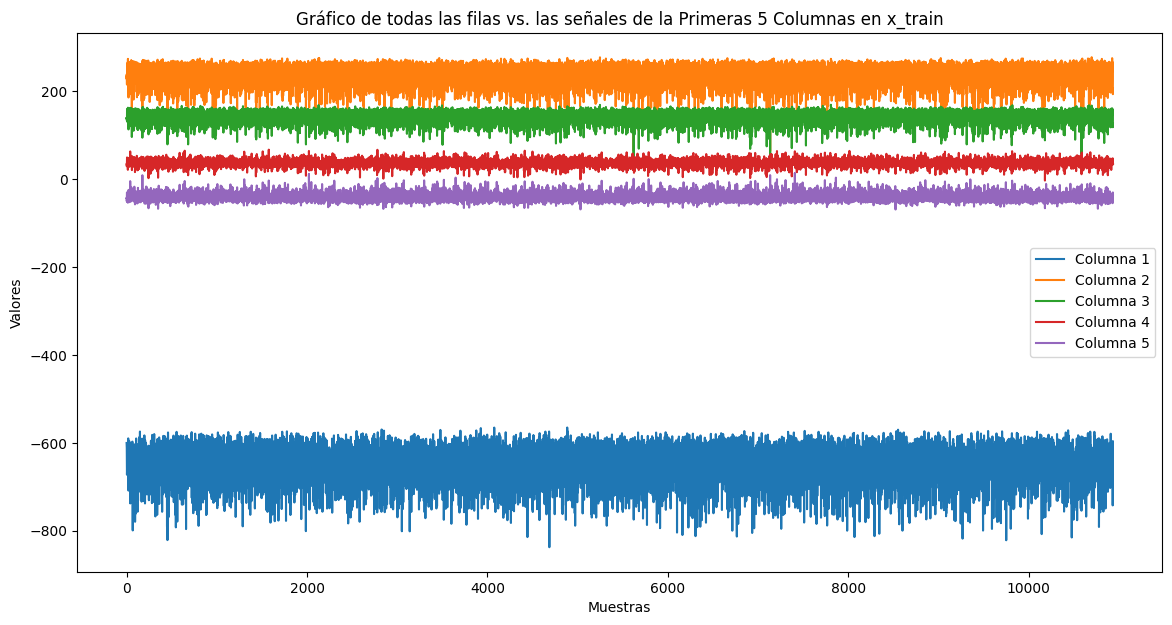

In [ ]:
# Gráfico de todas las filas vs. los primeros 5 columnas (features) de la matriz x_train
plt.figure(figsize=(14, 7))
for i in range(5):
    plt.plot(np.arange(x_train.shape[0]), x_train[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de todas las filas vs. las señales de la Primeras 5 Columnas en x_train')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

1
[-600.096      234.25362    139.46518     34.31441    -42.56482
  -69.03463    -50.098225   -11.511888    17.651896    21.978466
    5.211948   -16.145966   -26.173805   -19.922739    -4.579461
    7.462967     8.004723    -1.7313042  -13.392649   -18.404114 ]


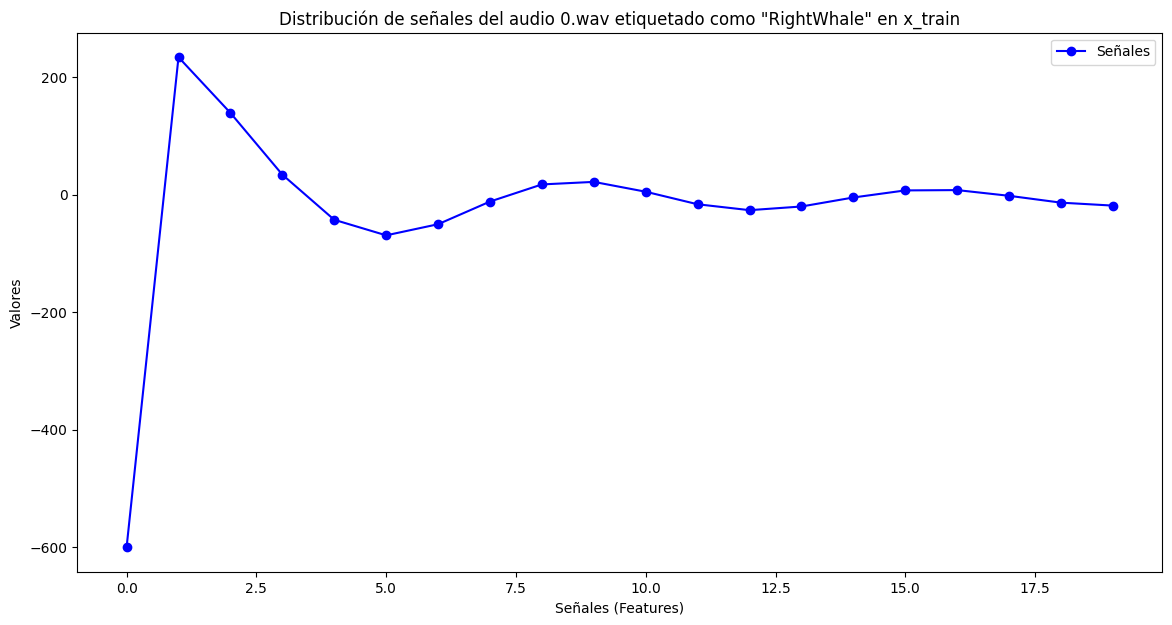

In [ ]:
#Grafico que muestra las señales de un audio 0.wav donde este etiqeutado como ballena RightWhale
print(y_train[0])
print(x_train[0])
audio_data = x_train[0]

# Graficar las señales del primer audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Distribución de señales del audio 0.wav etiquetado como "RightWhale" en x_train')
plt.xlabel('Señales (Features)')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

0
[-670.50775    207.45226    126.975365    34.11232    -34.13478
  -57.80968    -40.33026     -2.8260608   29.009327    38.706917
   26.065311     3.791873   -12.861765   -15.7741995   -7.1759586
    4.089703     9.599122     6.7453594   -0.7104236   -6.5099998]


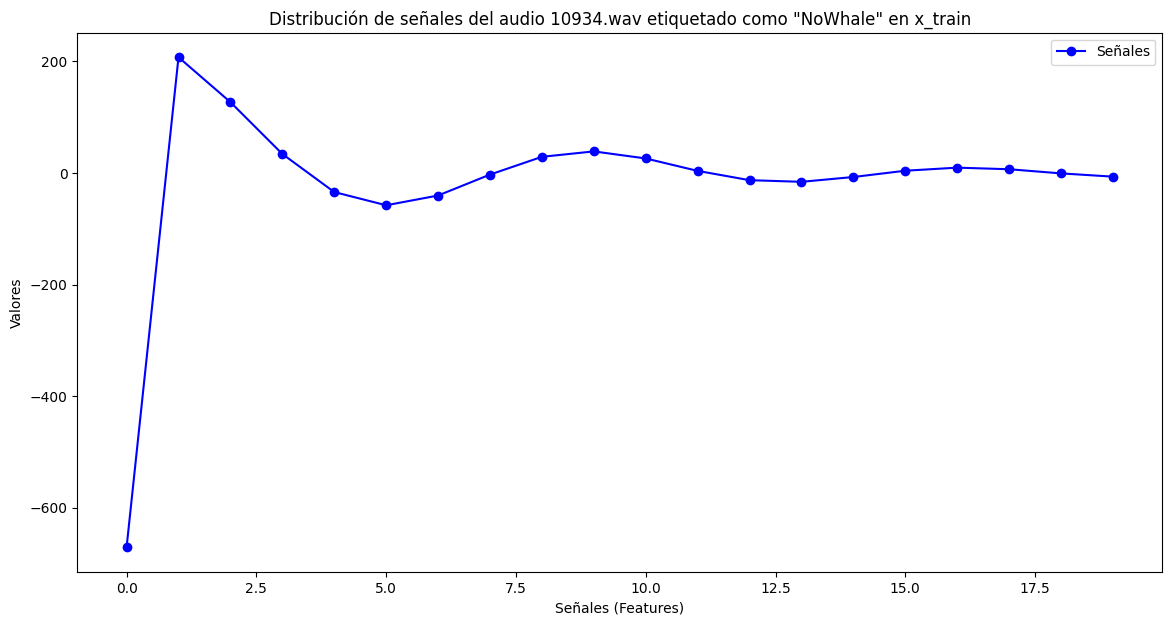

In [ ]:
#Grafico que muestra las señales de un audio 10934.wav donde este etiqueta como NoWhale
print(y_train[10933])

print(x_train[10933])
audio_data = x_train[10933]

# Graficar las señales del ultimo audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Distribución de señales del audio 10934.wav etiquetado como "NoWhale" en x_train')
plt.xlabel('Señales (Features)')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

## x_test

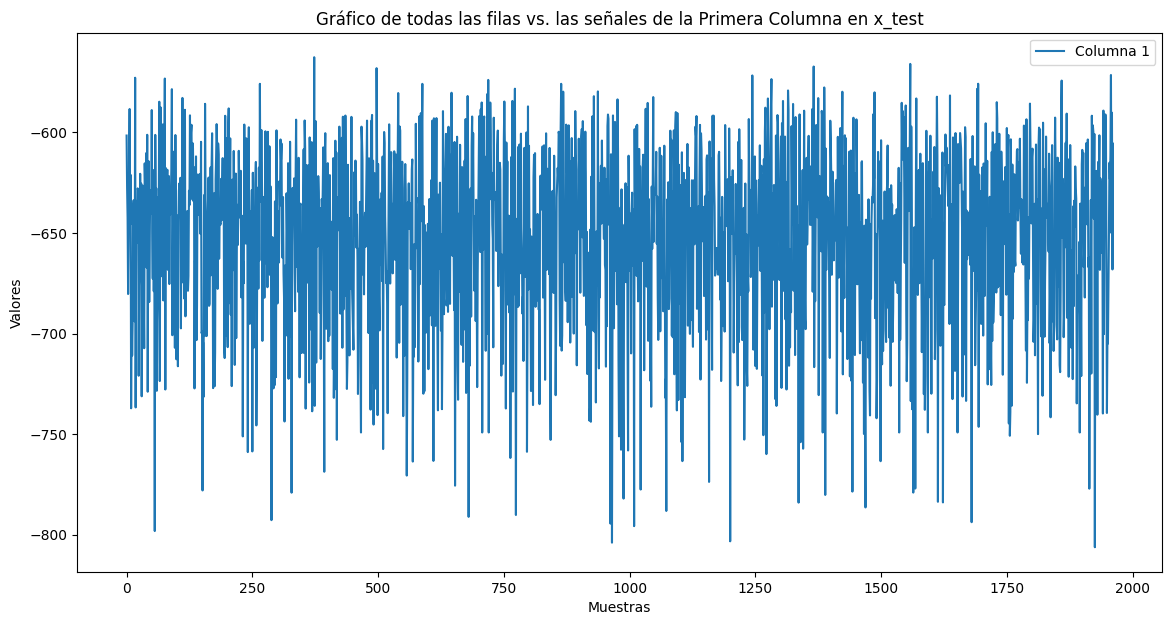

In [ ]:
# Gráfico de todas las filas vs. la primera columna (feature) de la matriz x_test
plt.figure(figsize=(14, 7))
for i in range(1):
    plt.plot(np.arange(x_test.shape[0]), x_test[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de todas las filas vs. las señales de la Primera Columna en x_test')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

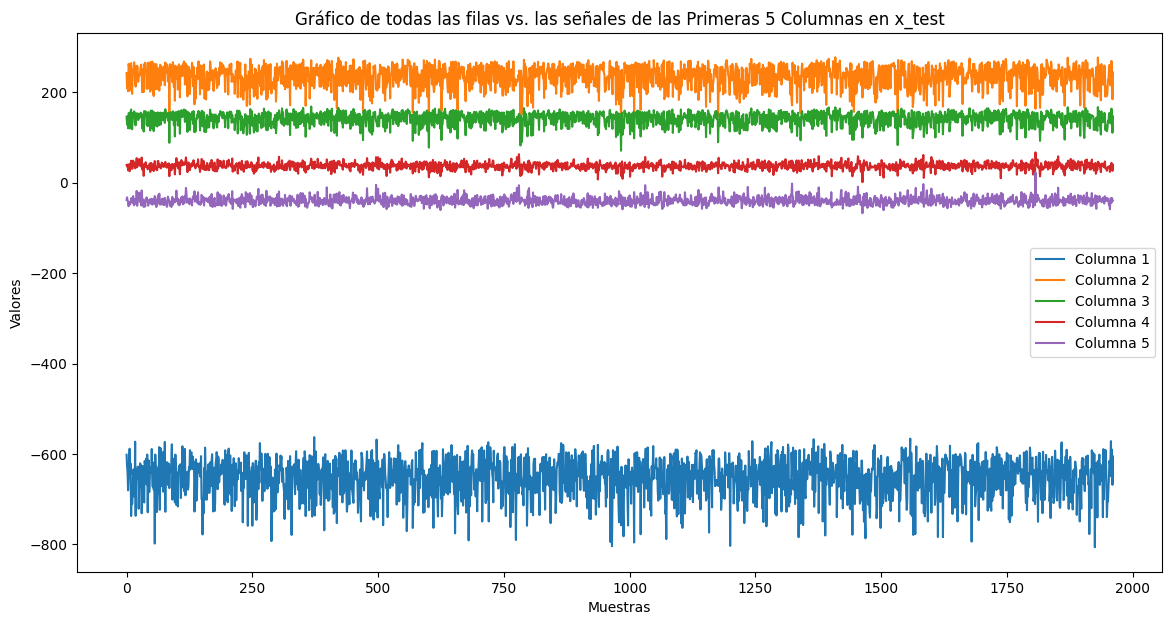

In [ ]:
# Gráfico de todas las filas vs. las primeras 5 columnas (features) de la matriz x_test
plt.figure(figsize=(14, 7))
for i in range(5):
    plt.plot(np.arange(x_test.shape[0]), x_test[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de todas las filas vs. las señales de las Primeras 5 Columnas en x_test')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

[-6.0159521e+02  2.4275156e+02  1.4611038e+02  3.9292805e+01
 -3.8122192e+01 -6.3725765e+01 -4.3603447e+01 -4.8592296e+00
  2.2950306e+01  2.4780275e+01  5.5631680e+00 -1.7119589e+01
 -2.7169092e+01 -2.0151810e+01 -4.1100368e+00  8.1299772e+00
  8.7162943e+00 -5.3103709e-01 -1.0962537e+01 -1.4437950e+01]


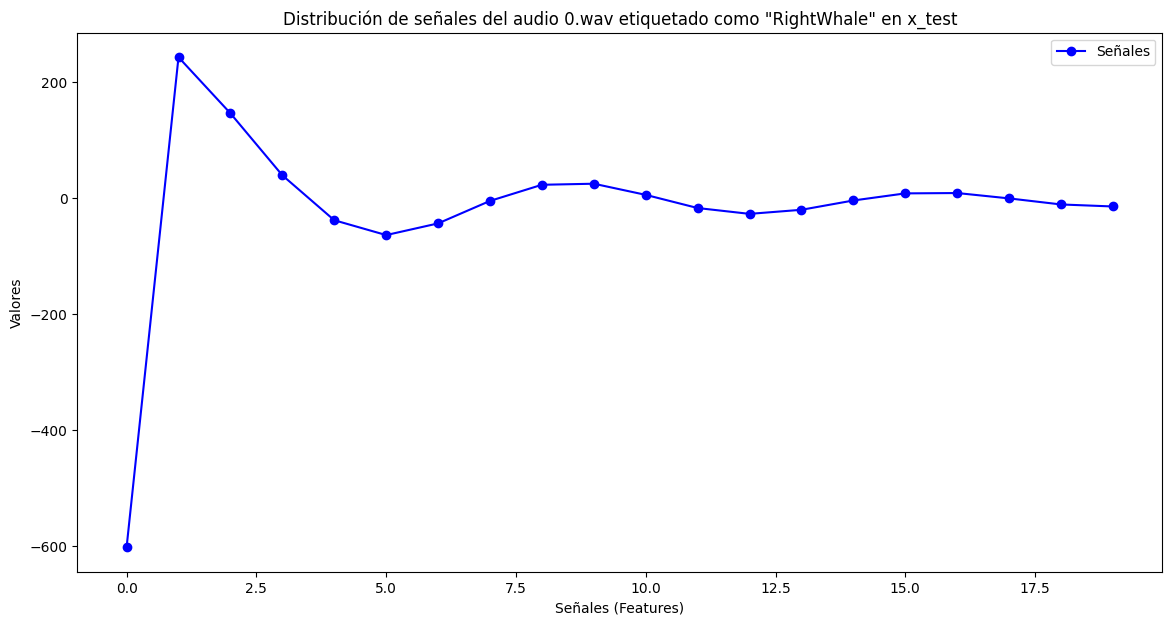

In [ ]:
#Grafico que muestra las señales de un audio 0.wav donde este etiqueta como RightWhale
print(x_test[0])
audio_data = x_test[0]

# Graficar las señales del primer audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Distribución de señales del audio 0.wav etiquetado como "RightWhale" en x_test')
plt.xlabel('Señales (Features)')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

[-605.6328     243.78273    146.6792      39.582104   -39.756813
  -68.42864    -50.99175    -13.261156    15.530476    19.552423
    2.4080257  -19.571033   -30.208918   -24.093739    -8.245608
    4.9491415    6.9688635   -1.5239668  -12.622127   -17.872633 ]


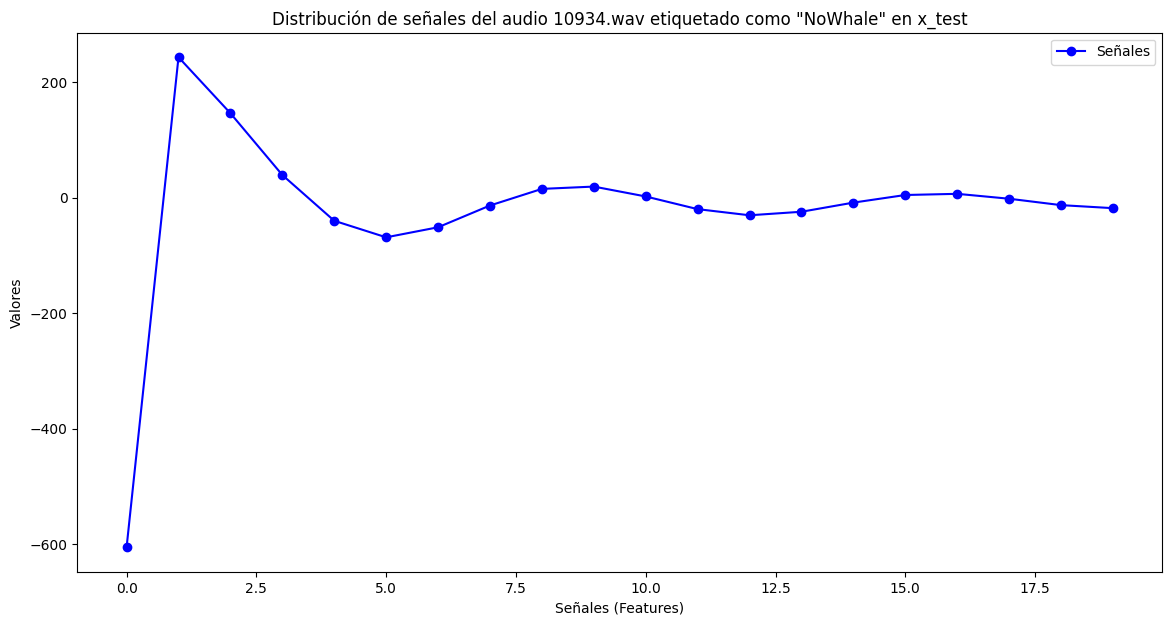

In [ ]:
#Grafico que muestra las señales de ultimo audio 1962.wav donde este etiquetado como ballena NoWhale
print(x_test[1961])
audio_data = x_test[1961]

# Graficar las señales del ultimo audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Distribución de señales del audio 10934.wav etiquetado como "NoWhale" en x_test')
plt.xlabel('Señales (Features)')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()